In [3]:
from pathlib import Path
import pickle
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.cluster import DBSCAN
import simplekml
from smount_predictors import SeamountHelp, SeamountTransformer
import xarray as xr
import pygmt

In [9]:
new_train_points = ((-117.1007646346129,-15.16349705205003), (-117.7208544442338,-18.88772023017733), (-110.5513357435865,-19.20600998877477), (-110.2604021311965,-15.47713254142141))
points = (-19.20600998877477, -15.16349705205003, -117.7208544442338, -110.2604021311965)

In [10]:
# points = SeamountHelp.readKMLbounds(Path('data/Seamount_training_zone.kml'))
data = SeamountHelp.readAndFilterGRD(Path('data/vgg_swot.grd'), points[:2], points[2:])

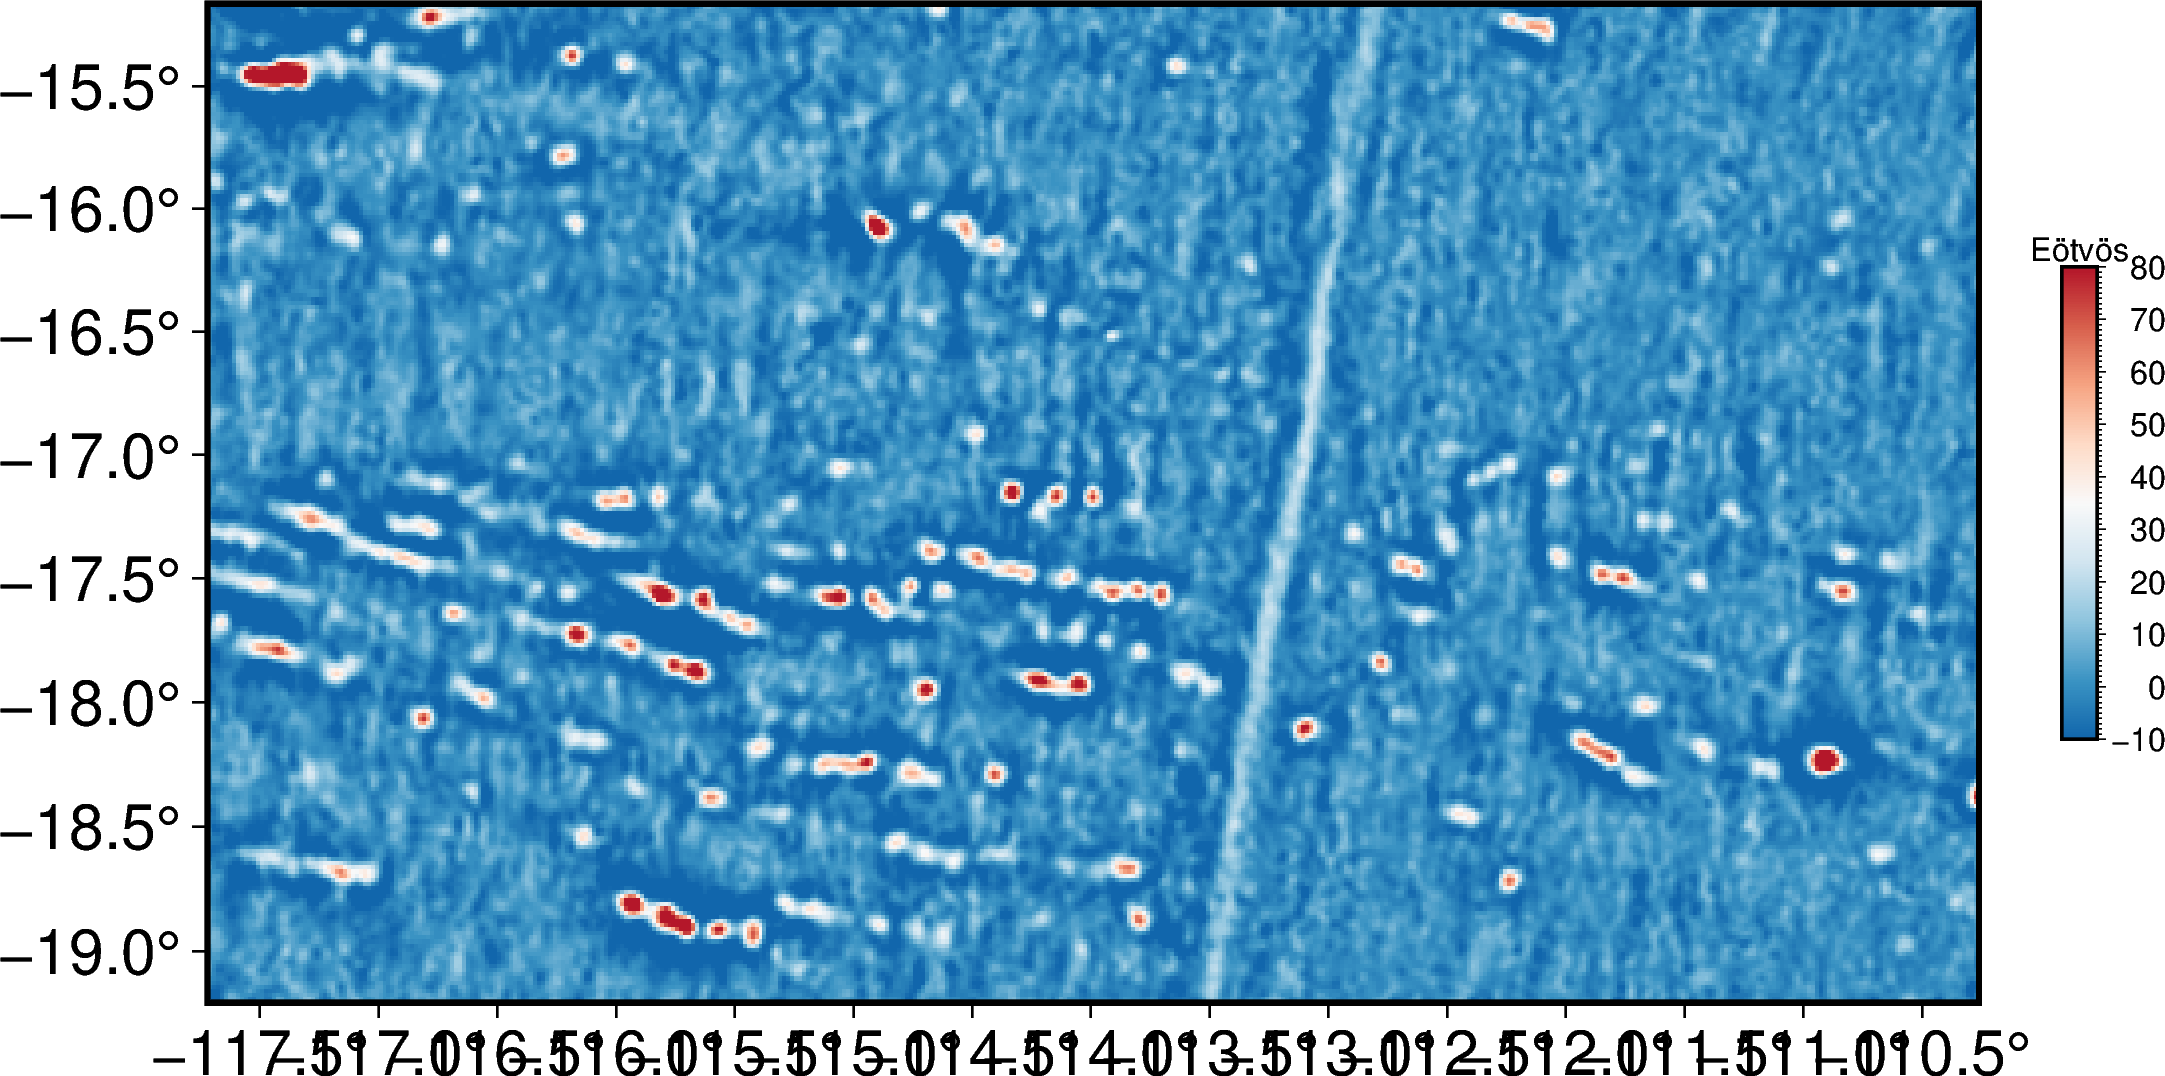

In [11]:
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", FONT_LABEL="15p,Helvetica,black", FONT_ANNOT="15p")
pygmt.config(FONT_ANNOT_PRIMARY="15p,Helvetica,black")

############################ SWIR ##################################
vgg_train_zone = data
pygmt.makecpt(cmap="data/colors.cpt", series=[-10, 80, 0.5], background='o')
fig.grdimage(
    grid = xr.DataArray(vgg_train_zone.z, coords=(vgg_train_zone.lat, vgg_train_zone.lon)),
    # shading = shade_SWIR,
    projection="M15c",
    region = [points[2], points[3], points[0], points[1]],
    frame=["WSrt", "xa0.5", "ya0.5"],
    cmap = True,
)
fig.colorbar(position="JML+o-16c/0c+w4c/0.3c+m", frame=["xa10f1", "y+lEötvös"])
# old_vgg_file = xr.open_dataset("/Volumes/envisat2/SWOT/src/sandwell/grid_swot/curv_32.1.nc")
fig.show()

In [18]:
data = xr.open_dataset("data/training_zone.grd")

In [19]:
dest = 'test_files'

### Full transformed data

In [20]:
full_trans_z = SeamountTransformer().fit_transform(data.to_dataframe().reset_index())
full_trans = data.to_dataframe().reset_index()
full_trans['z'] = full_trans_z.reshape(-1)
full_trans = xr.Dataset().from_dataframe(full_trans.set_index(['lon', 'lat']))
full_trans.to_netcdf('data/'+f'{dest}'+'/full_trans.nc')

### Non inverted rings

In [21]:
nokern = SeamountTransformer()
nokern.CONV_KERN = np.array([[1]])
non_inv_z = nokern.fit_transform(data.to_dataframe().reset_index())
non_inv = data.to_dataframe().reset_index()
non_inv['z'] = non_inv_z.reshape(-1)
non_inv = xr.Dataset().from_dataframe(non_inv)
non_inv.to_netcdf('data/'+f'{dest}'+'/non_inverted_trans.nc')

### Sobel Filtered data

In [22]:
from scipy.signal import convolve
from scipy.ndimage import gaussian_filter, sobel

X = data.to_dataframe().reset_index()
df = pd.DataFrame(X, columns=['lat', 'lon', 'z'])
df.set_index(['lat', 'lon'], inplace=True)
data_index = df.index
if df.index.duplicated().any():
    df = df[~df.index.duplicated()]
Xxr = df.to_xarray()
Xxr['z'] = Xxr['z'].fillna(0)
# Scaling for y axis. NOTE: since this uses the mean, the larger the area
# the less accurate the scaling. Works best in small areas.
sigma = 1
x1_sig = sigma / np.cos(np.radians(Xxr['lat'].values.mean()))
# Filtering to smooth data, and find gradient peaks
smoothed = gaussian_filter(Xxr['z'].values, sigma=(sigma, x1_sig))
y_grad = sobel(smoothed, axis=0)
x_grad = sobel(smoothed, axis=1)
grad = np.hypot(x_grad, y_grad)
transed = smoothed * grad
Xxr['z'].values = transed
Xxr.to_netcdf('data/'+f'{dest}'+'/sobel_trans.nc')

### Gausian Filtered data

In [23]:
X = data.to_dataframe().reset_index()
df = pd.DataFrame(X, columns=['lat', 'lon', 'z'])
df.set_index(['lat', 'lon'], inplace=True)
data_index = df.index
if df.index.duplicated().any():
    df = df[~df.index.duplicated()]
Xxr = df.to_xarray()
Xxr['z'] = Xxr['z'].fillna(0)
# Scaling for y axis. NOTE: since this uses the mean, the larger the area
# the less accurate the scaling. Works best in small areas.
sigma = 1
x1_sig = sigma / np.cos(np.radians(Xxr['lat'].values.mean()))
# Filtering to smooth data, and find gradient peaks
smoothed = gaussian_filter(Xxr['z'].values, sigma=(sigma, x1_sig))
Xxr['z'].values = smoothed
Xxr.to_netcdf('data/'+f'{dest}'+'/gaus_trans.nc')

### Raw VGG

In [24]:
data.to_netcdf('data/'+f'{dest}'+'/raw_data.nc')

# SRTM and 3d plotting code - do not change

In [25]:
srtm = SeamountHelp.readAndFilterGRD(Path("data/SRTM15_V2.5.nc"), points[:2], points[2:])
srtm.to_netcdf('data/'+f'{dest}'+'/srtm_train_zone.nc')
# SeamountHelp.plot_xarr(srtm, name="SRTM of training zone", backend='plt')

In [26]:
datadf = data.to_dataframe().reset_index()
bigmount = datadf[(datadf['lat'] >= -18.6) & (datadf['lat'] <= -18.0) & (datadf['lon'] >= -111.2) & (datadf['lon'] <= -110.6)]
# px.scatter(bigmount, x='lon', y='lat', color='z')

In [28]:
import pickle
from smount_predictors.src.SeamountHelp import PipelinePredictor
from sklearn.preprocessing import StandardScaler
model = pickle.load(open('out/cluster_tuned_model.pkl', 'rb'))
svc_model = model.model
threshold = -svc_model.named_steps['predictor'].intercept_[0] / svc_model.named_steps['predictor'].coef_[0][0]
# print("Threshold for the hyperplane:", threshold)

In [29]:
from smount_predictors import SeamountTransformer
trans = SeamountTransformer()
bigmount['z'] = trans.fit_transform(bigmount).reshape(-1)

/var/folders/v7/nxggzv_j5s936v9rvl85gh2w0000gn/T/ipykernel_21972/1263929631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigmount['z'] = trans.fit_transform(bigmount).reshape(-1)


In [30]:
import numpy as np
# Define xx and yy
xx, yy = np.meshgrid(np.linspace(bigmount['lon'].min(), bigmount['lon'].max(), 100),
                     np.linspace(bigmount['lat'].min(), bigmount['lat'].max(), 100))
import plotly.graph_objects as go
fig = px.scatter_3d(bigmount, x='lon', y='lat', z='z')
plane = go.Surface(
    z=2.47695002 * np.ones_like(xx),
    x=xx,
    y=yy,
    colorscale=[[0, 'green'], [1, 'green']],
    opacity=0.5,
    showscale=False
)
fig.add_trace(plane)
fig.update_layout(
    autosize=False,
    width=900,
    height=800
);
# fig.show()

In [ ]:
import pandas as pd
import numpy as np

predict = pd.read_csv('out/predictions.csv')
predict = predict.groupby('cluster').mean()
predict = predict[(predict[predict['lat'] < 18]) & (predict['lat'] > -2) & (predict['lon'] < -130) & (predict['lon'] > -150) & (predict['cluster'] != -1)]
predict.head()
